# DQN Implementation to solve "Lunar Lander" Discrete version

The Lunar Lander environment from OpenAI Gym represents a classic reinforcement learning challenge where an agent must learn to safely land a spacecraft on a designated landing pad. This implementation demonstrates the power of Deep Q-Network (DQN) in solving complex, continuous state-space problems through intelligent exploration and learning.

#### Loading Dependencies

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import trange
from collections import deque
from typing import Tuple, List

# Pour l'optimisation bayésienne
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_objective

In [ ]:
# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

The Experience class represents an atomic unit of information in this replay mechanism,
capturing the essential elements of a single interaction with the environment.

In [ ]:
class Experience:
    """
    A class to store individual experience tuples for reinforcement learning.
    
    Attributes:
        state (np.ndarray): The current state of the environment.
        action (int): The action taken.
        reward (float): The reward received.
        next_state (np.ndarray): The next state after taking the action.
        done (bool): Whether the episode has terminated.
    """
    def __init__(self, state: np.ndarray, action: int, reward: float, 
                 next_state: np.ndarray, done: bool):
        self.state = state
        self.action = action
        self.reward = reward
        self.next_state = next_state
        self.done = done

The replay buffer transforms on-policy learning into an off-policy method,
enabling more stable and efficient neural network training in reinforcement learning.

In [ ]:
class ExperienceReplayBuffer:
    """
    A replay buffer to store and sample experiences for deep reinforcement learning.
    
    Attributes:
        buffer (deque): A double-ended queue to store experiences.
        maximum_length (int): Maximum number of experiences to store.
    """
    def __init__(self, maximum_length: int = 10000):
        self.buffer = deque(maxlen=maximum_length)
        self.maximum_length = maximum_length
    
    def append(self, experience: Experience) -> None:
        """
        Add an experience to the replay buffer.
        
        Args:
            experience (Experience): The experience to add.
        """
        self.buffer.append(experience)
        
    def __len__(self) -> int:
        """
        Get the current number of experiences in the buffer.
        
        Returns:
            int: Number of experiences in the buffer.
        """
        return len(self.buffer)
    
    def sample_batch(self, n: int) -> Tuple[np.ndarray, ...]:
        """
        Sample a batch of experiences from the replay buffer.
        
        Args:
            n (int): Number of experiences to sample.
        
        Returns:
            Tuple of numpy arrays containing states, actions, rewards, next_states, and done flags.
        """
        n = min(n, len(self.buffer))
        
        indices = np.random.choice(
            len(self.buffer),
            size=n,
            replace=False
        )
        
        batch = [self.buffer[i] for i in indices]
        
        states = np.array([exp.state for exp in batch])
        actions = np.array([exp.action for exp in batch])
        rewards = np.array([exp.reward for exp in batch])
        next_states = np.array([exp.next_state for exp in batch])
        dones = np.array([exp.done for exp in batch])
        
        return states, actions, rewards, next_states, dones

This code defines a RandomAgent class, which is a simple agent that chooses actions randomly. This is often used as a baseline or for initial exploration in reinforcement learning.

In [ ]:
class RandomAgent:
    """
    An agent that selects random actions for exploration.
    
    Attributes:
        n_actions (int): Number of possible actions in the environment.
    """
    def __init__(self, n_actions: int):
        """
        Initialize the RandomAgent.
        
        Args:
            n_actions (int): Number of possible actions in the environment.
        """
        self.n_actions = n_actions
        
    def forward(self, state: np.ndarray) -> int:
        """
        Select a random action.
        
        Args:
            state (np.ndarray): Current environment state (not used for random action).
        
        Returns:
            int: Randomly selected action.
        """
        return np.random.randint(0, self.n_actions)

This code defines a **DeepQLearningAgent** class, which implements a simple feedforward neural network for Deep Q-Learning (DQN). This network approximates the Q-value function, which maps states and actions to their expected future rewards.

In [ ]:
class DeepQLearningAgent(nn.Module):
    """
    Deep Q-Learning neural network for action-value function approximation.
    
    Attributes:
        fc1 (nn.Linear): First fully connected layer.
        fc2 (nn.Linear): Second fully connected layer.
        fc3 (nn.Linear): Output layer.
    """
    def __init__(self, input_size: int, output_size: int, hidden_size: int = 50):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the neural network.
        
        Args:
            x (torch.Tensor): Input state tensor.
        
        Returns:
            torch.Tensor: Q-values for each action.
        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
    def predict(self, state, deterministic=True):
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
            q_values = self.forward(state_tensor)
            action = torch.argmax(q_values).item()  # Select action with highest Q-value
        return action

This function implements epsilon decay, a common strategy for controlling the exploration-exploitation trade-off in reinforcement learning.

In [ ]:
def epsilon_decay(episode: int, total_episodes: int, 
                  eps_max: float = 0.9, 
                  eps_min: float = 0.05, 
                  method: str = "linear") -> float:
    """
    Compute the epsilon value for exploration-exploitation trade-off.
    
    Args:
        episode (int): Current episode number.
        total_episodes (int): Total number of training episodes.
        eps_max (float, optional): Maximum exploration rate. Defaults to 0.9.
        eps_min (float, optional): Minimum exploration rate. Defaults to 0.05.
        method (str, optional): Decay method. Defaults to "linear".
    
    Returns:
        float: Computed epsilon value.
    """
    if method == "linear":
        decay_point = int(0.93 * total_episodes)
        return max(eps_min, eps_max - (eps_max - eps_min) * (episode / decay_point))
    else:  # Exponential decay
        return eps_min + (eps_max - eps_min) * np.exp(-1. * episode / total_episodes)


This function computes the running average of a list of numbers, which is useful for smoothing noisy data, such as episode rewards.

In [ ]:
def running_average(data: List[float], window_size: int) -> np.ndarray:
    """
    Compute the running average of a list with a specified window size.
    
    Args:
        data (List[float]): Input data list.
        window_size (int): Size of the moving window.
    
    Returns:
        np.ndarray: Array of running averages.
    """
    cumsum = np.cumsum(np.insert(data, 0, 0)) 
    return (cumsum[window_size:] - cumsum[:-window_size]) / window_size

This function implements the training loop for a Deep Q-Learning (DQN) agent in the Lunar Lander environment.

In [ ]:
def train_lunar_lander(
    env_name: str = 'LunarLander-v3', 
    n_episodes: int = 600, 
    discount_factor: float = 0.7,
    learning_rate: float = 0.001,
    hidden_size: int = 50,
    max_norm: float = 0.5,
    replay_buffer_size: int = 50000,
    batch_size: int = 54,
    target_update_frequency: int = 1000,
    n_ep_running_average: int = 50
) -> Tuple[List[float], List[int]]:
    """
    Train a Deep Q-Learning agent in the Lunar Lander environment.
    
    Args:
        env_name (str): Name of the gym environment. Defaults to 'LunarLander-v3'.
        n_episodes (int): Number of training episodes. Defaults to 600.
        discount_factor (float): Discount factor for future rewards. Defaults to 1.0.
        learning_rate (float): Learning rate for the optimizer. Defaults to 0.001.
        hidden_size (int): Size of the hidden layer for the Q-network. Defaults to 70.
        max_norm (float): Gradient clipping norm. Defaults to 0.5.
        replay_buffer_size (int): Size of the experience replay buffer. Defaults to 50000.
        batch_size (int): Size of each training batch. Defaults to 54.
        target_update_frequency (int): Frequency of updating the target network. Defaults to 1000.
        n_ep_running_average (int): Number of episodes for the running average. Defaults to 50.
    
    Returns:
        Tuple containing episode rewards and number of steps per episode.
    """
    # Environment setup
    env = gym.make(env_name)
    state, _ = env.reset()

    # Hyperparameters (configurable via arguments)
    n_actions = env.action_space.n
    dim_state = len(env.observation_space.high)

    # Initialize components
    buffer = ExperienceReplayBuffer(maximum_length=replay_buffer_size)
    network = DeepQLearningAgent(input_size=dim_state, output_size=n_actions, hidden_size=int(hidden_size))
    target_network = DeepQLearningAgent(input_size=dim_state, output_size=n_actions, hidden_size=int(hidden_size))
    target_network.load_state_dict(network.state_dict())
    optimizer = optim.Adam(network.parameters(), lr=learning_rate)

    # Training metrics
    episode_reward_list = []
    episode_number_of_steps = []
    max_score = float('-inf')
    steps = 0

    # Training loop
    for episode in trange(n_episodes, desc="Training Progress"):
        state, _ = env.reset()
        total_episode_reward = 0
        done = False
        t = 0

        # Epsilon decay strategy
        epsilon = epsilon_decay(episode, n_episodes)

        while not done and t < 1000:
            # Epsilon-greedy action selection
            state_tensor = torch.tensor([state], dtype=torch.float32)
            
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                network.eval()
                with torch.no_grad():
                    values = network(state_tensor)
                    action = values.max(1)[1].item()

            # Environment interaction
            next_state, reward, done, _, _ = env.step(action)
            total_episode_reward += reward

            # Store experience
            exp = Experience(state, action, reward, next_state, done)
            buffer.append(exp)
            state = next_state

            steps += 1
            t += 1

            # Training step
            if len(buffer) >= batch_size:
                states, actions, rewards, next_states, dones = buffer.sample_batch(batch_size)

                # Tensor conversions
                states_tensor = torch.tensor(states, dtype=torch.float32)
                actions_tensor = torch.tensor(actions, dtype=torch.int64)
                rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
                next_states_tensor = torch.tensor(next_states, dtype=torch.float32)
                dones_tensor = torch.tensor(dones, dtype=torch.float32)

                # Q-value computations
                current_q_values = network(states_tensor)
                action_masks = F.one_hot(actions_tensor, n_actions)
                predicted_q_values = (action_masks * current_q_values).sum(dim=1)

                with torch.no_grad():
                    next_q_values = target_network(next_states_tensor)
                    max_next_q_values = next_q_values.max(1)[0]
                    target_q_values = rewards_tensor + discount_factor * (1 - dones_tensor) * max_next_q_values

                # Optimization
                loss = F.mse_loss(predicted_q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(network.parameters(), max_norm=max_norm)
                optimizer.step()

            # Periodic target network update
            if steps % target_update_frequency == 0:
                target_network.load_state_dict(network.state_dict())

        # Episode metrics
        episode_reward_list.append(total_episode_reward)
        episode_number_of_steps.append(t)

        # Compute running average
        avg_reward = np.mean(episode_reward_list[-n_ep_running_average:])
        
        if avg_reward > max_score:
            max_score = avg_reward
            torch.save(network.state_dict(), "models/dqn_model.pth")

    env.close()
    return episode_reward_list, episode_number_of_steps


NameError: name 'Tuple' is not defined

This function plots the training results, showing the episode rewards and steps per episode, along with their running averages.

In [ ]:
def plot_training_results(episode_reward_list: List[float], 
                           episode_number_of_steps: List[int], 
                           n_ep_running_average: int = 30) -> None:
    """
    Plot training results showing rewards and steps per episode.
    
    Args:
        episode_reward_list (List[float]): List of rewards per episode.
        episode_number_of_steps (List[int]): List of steps per episode.
        n_ep_running_average (int, optional): Window size for running average. Defaults to 50.
    """
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))

    # Reward plot
    x_rewards = range(1, len(episode_reward_list) + 1)
    ax1.plot(x_rewards, episode_reward_list, label='Episode reward')
    
    avg_rewards = running_average(episode_reward_list, n_ep_running_average)
    ax1.plot(range(n_ep_running_average, len(episode_reward_list) + 1), 
             avg_rewards, label='Avg. episode reward')
    
    ax1.set_xlabel('Episodes')
    ax1.set_ylabel('Total reward')
    ax1.set_title('Total Reward vs Episodes')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Steps plot
    x_steps = range(1, len(episode_number_of_steps) + 1)
    ax2.plot(x_steps, episode_number_of_steps, label='Steps per episode')
    
    avg_steps = running_average(episode_number_of_steps, n_ep_running_average)
    ax2.plot(range(n_ep_running_average, len(episode_number_of_steps) + 1), 
             avg_steps, label='Avg. number of steps per episode')
    
    ax2.set_xlabel('Episodes')
    ax2.set_ylabel('Total number of steps')
    ax2.set_title('Total number of steps vs Episodes')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

### First Implementation

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Training Progress: 100%|██████████| 600/600 [21:44<00:00,  2.17s/it]


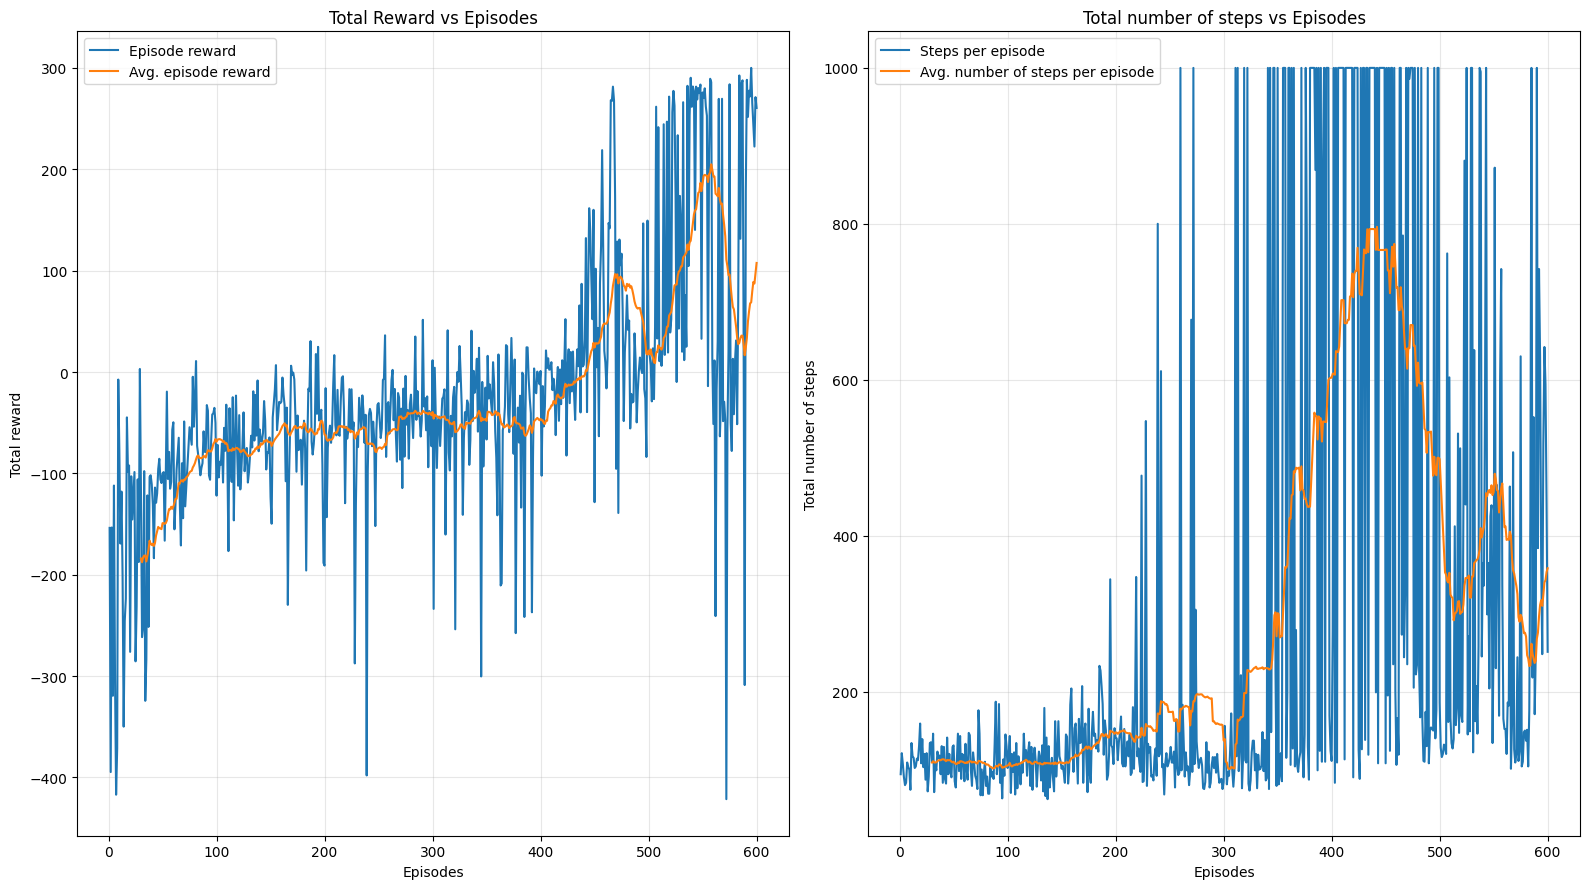

In [15]:
episode_rewards, episode_steps = train_lunar_lander()
plot_training_results(episode_rewards, episode_steps)


## Comparing different hyperparameters

### Comparing different discounted factors

In [55]:
def plot_multiple_training_results(training_results: List[Tuple[List[float], List[int], float]], 
                                    n_ep_running_average: int = 30) -> None:
    """
    Plot training results for multiple runs with different discount factors.
    
    Args:
        training_results (List[Tuple[List[float], List[int], float]]): 
            A list of tuples containing (episode_rewards, episode_steps, discount_factor)
        n_ep_running_average (int, optional): Window size for running average. Defaults to 50.
    """
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))

    # Color palette for different runs
    colors = ['blue', 'red', 'green', 'purple', 'orange']

    # Reward plot
    for (episode_rewards, _, discount_factor), color in zip(training_results, colors):
        avg_rewards = running_average(episode_rewards, n_ep_running_average)
        ax1.plot(range(n_ep_running_average, len(episode_rewards) + 1), 
                 avg_rewards, label=f'Avg. γ = {discount_factor}', color=color, linestyle='--')
    
    ax1.set_xlabel('Episodes')
    ax1.set_ylabel('Total reward')
    ax1.set_title('Total Reward vs Episodes')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Steps plot
    for (_, episode_steps, discount_factor), color in zip(training_results, colors):
        avg_steps = running_average(episode_steps, n_ep_running_average)
        ax2.plot(range(n_ep_running_average, len(episode_steps) + 1), 
                 avg_steps, label=f'Avg. γ = {discount_factor}', color=color, linestyle='--')
    
    ax2.set_xlabel('Episodes')
    ax2.set_ylabel('Total number of steps')
    ax2.set_title('Total number of steps vs Episodes')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


Training with discount factor γ = 0.2


Training Progress: 100%|██████████| 300/300 [04:21<00:00,  1.15it/s]


Training with discount factor γ = 0.5


Training Progress: 100%|██████████| 300/300 [04:05<00:00,  1.22it/s]


Training with discount factor γ = 1.0


Training Progress: 100%|██████████| 300/300 [07:34<00:00,  1.52s/it]


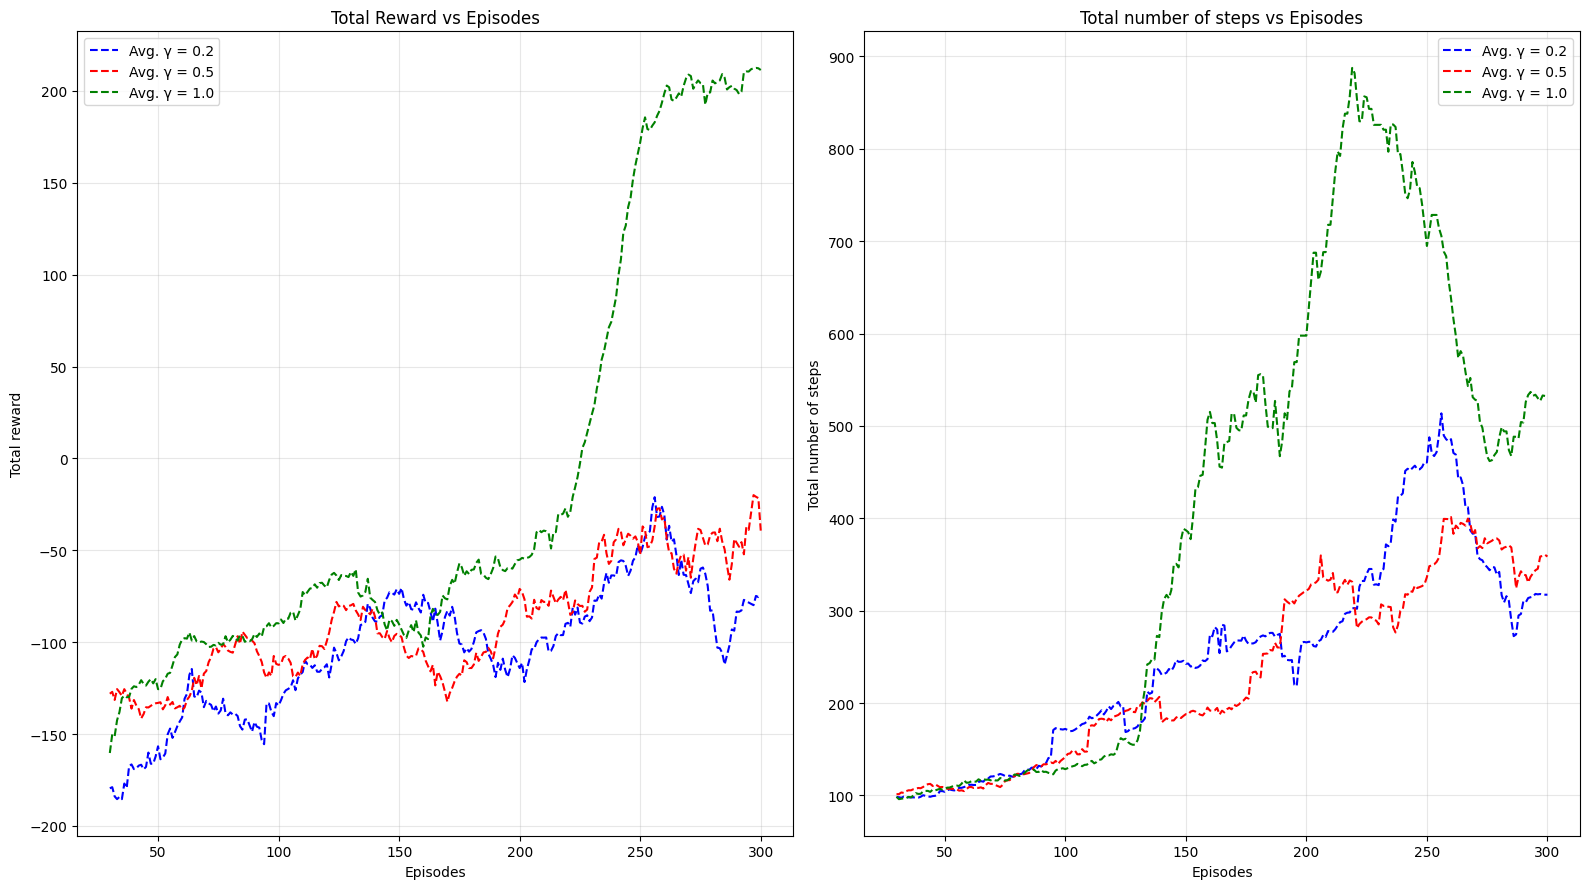

Training and comparison completed successfully.


In [ ]:
def compareDiscountFactors():
    """
    compareDiscountFactors function to compare Lunar Lander agent training with different discount factors.
    """
    try:
        # List of discount factors to compare
        discount_factors = [0.2, 0.5, 1.0]
        
        # Train multiple models with different discount factors
        training_results = []
        for gamma in discount_factors:
            print(f"Training with discount factor γ = {gamma}")
            episode_rewards, episode_steps = train_lunar_lander(
                discount_factor=gamma, 
                n_episodes=300  # Reduced for faster comparison
            )
            training_results.append((episode_rewards, episode_steps, gamma))
        
        # Plot comparative results
        plot_multiple_training_results(training_results)
        print('Training and comparison completed successfully.')
    
    except Exception as e:
        print(f"An error occurred during training: {e}")


if __name__ == "__main__":
    compareDiscountFactors()

In [69]:
def compare_hidden_sizes():
    """
    Compare training performance of Lunar Lander agent with different hidden layer sizes.
    """
    try:
        # List of hidden layer sizes to compare
        hidden_sizes = [50, 100, 150]
       
        # Train multiple models with different hidden sizes
        training_results = []
        for hidden_size in hidden_sizes:
            print(f"Training with hidden size = {hidden_size}")
            episode_rewards, episode_steps = train_lunar_lander(
                hidden_size=hidden_size,
                n_episodes=600,
                discount_factor=1.0,  # Best discount factor
            )
            print(episode_rewards, episode_steps)
            training_results.append((episode_rewards, episode_steps, hidden_size))
       
        # Plot comparative results
        plot_multiple_training_results(training_results)
        print('Training and comparison completed successfully.')
   
    except Exception as e:
        print(f"An error occurred during training: {e}")


def plot_multiple_training_results(training_results: List[Tuple[List[float], List[int], float]],
                                    n_ep_running_average: int = 30) -> None:
    """
    Plot training results for multiple runs with different hidden layer sizes.
   
    Args:
        training_results (List[Tuple[List[float], List[int], float]]):
            A list of tuples containing (episode_rewards, episode_steps, hidden_size)
        n_ep_running_average (int, optional): Window size for running average. Defaults to 30.
    """
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
    # Color palette for different runs
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    
    # Reward plot
    for i, ((episode_rewards, episode_steps, hidden_size), color) in enumerate(zip(training_results, colors)):
        avg_rewards = running_average(episode_rewards, n_ep_running_average)
        ax1.plot(range(n_ep_running_average, len(episode_rewards) + 1),
                 avg_rewards, label=f'Hidden Size = {hidden_size}', color=color, linestyle='--')
   
    ax1.set_xlabel('Episodes')
    ax1.set_ylabel('Total reward')
    ax1.set_title('Total Reward vs Episodes')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Steps plot
    for ((episode_rewards, episode_steps, hidden_size), color) in zip(training_results, colors):
        avg_steps = running_average(episode_steps, n_ep_running_average)
        ax2.plot(range(n_ep_running_average, len(episode_steps) + 1),
                 avg_steps, label=f'Hidden Size = {hidden_size}', color=color, linestyle='--')
   
    ax2.set_xlabel('Episodes')
    ax2.set_ylabel('Total number of steps')
    ax2.set_title('Total number of steps vs Episodes')
    ax2.legend()
    ax2.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

Training with hidden size = 50


Training Progress: 100%|██████████| 600/600 [20:16<00:00,  2.03s/it]


[-170.5787512743031, -90.04034510221481, -137.63448977359135, -363.10372087712705, -559.1816941610366, -170.44340841579896, -155.72323656128918, -89.65648074174669, -57.99382022244017, -105.38115740836096, -100.17275452157423, -134.9966461518414, -195.54516880863983, -453.00392544393173, -164.6467626218968, -119.4921058046463, -164.3387077828702, -120.46382665440045, -236.46575788751522, -173.09523629863583, -198.8684920865598, -223.727922823547, -143.2387541579124, -75.36440297353934, -109.29627815589853, -108.6279341784961, -130.94958667592869, -175.53027047651273, -125.1652992916102, -28.17734412159183, -81.73480506650841, -292.56514427597915, -17.804773200878273, -76.3721910052149, -137.72818531304262, -119.94697733997512, -93.79679256849586, -217.06342464883727, -100.22675027400538, -72.81236169852644, -132.04319335698372, -110.07631709541005, -103.36252324444607, -62.34803408213137, 17.01277769142942, -50.27819933462152, -238.02287370645416, -25.767894905020015, -120.620240138509

Training Progress: 100%|██████████| 600/600 [14:15<00:00,  1.43s/it]


[-99.15867028050222, -437.6087105600944, -84.14638717061001, -265.7678118434802, -42.63287077758999, -197.71802281968235, -230.88730641299975, -32.15445041880159, -246.40093369372556, -284.3660866105753, -360.4228439044744, -135.7669963276171, -108.67198232284332, -111.89396483127436, -114.45720323346029, -193.10922581866726, -99.84851480673257, -50.41247588641019, -185.10774579413294, -219.43822013727294, -71.0037798900411, -220.69418633005213, -219.95589401958455, -274.9923260492292, -141.0706277338499, -150.2839805396566, -47.156732027142546, -99.84521710101072, -81.6025357331502, -90.79357434015765, -79.8020301863472, -89.07869113811961, -226.6762903267158, -185.70539622997956, -51.93291913555345, -120.35533393070071, -178.25757424896887, -59.26334855229066, -64.18611687725563, -112.30201818542233, -134.12919489023847, -112.30860509337876, -104.87569681674118, -102.49711187570338, -124.00159979775, -151.57640094795426, -127.18891321185686, -183.84887057680157, -97.11200754705706, -

Training Progress: 100%|██████████| 600/600 [13:58<00:00,  1.40s/it]


[-347.032312173988, -42.63928498163888, -492.5296311501007, -105.5877851192705, -267.2931185278767, -57.187183231706264, -143.83551311042828, 21.50056849050334, -34.66196173084664, -108.28052995570815, -126.14775663316182, -312.43913975058774, -147.38046926684382, -196.34001191708808, -380.0606319634482, -101.68509696167413, -261.63340491348623, -60.227182208377144, -16.964006417107754, -137.9810868384276, -141.47469154220818, -94.89733999253998, -226.71573803766455, -115.53059741415437, -112.95439529466918, -159.34233402434967, -361.8002126284953, -197.31580358844894, -109.34143388788085, -144.1069948646824, -185.81504186129098, -321.1865315041971, -126.05098514483794, -166.9321915290781, -116.32664486398403, -212.6048492545569, -180.5084803476739, 24.7063887063225, -151.46716331534714, -105.22184228973887, -187.7423989751472, -90.16603675194649, -104.33215293891527, -101.38959516274988, -186.99347535478182, -97.16736099649653, -82.40640982488853, -81.4968404400709, -83.27569682854238

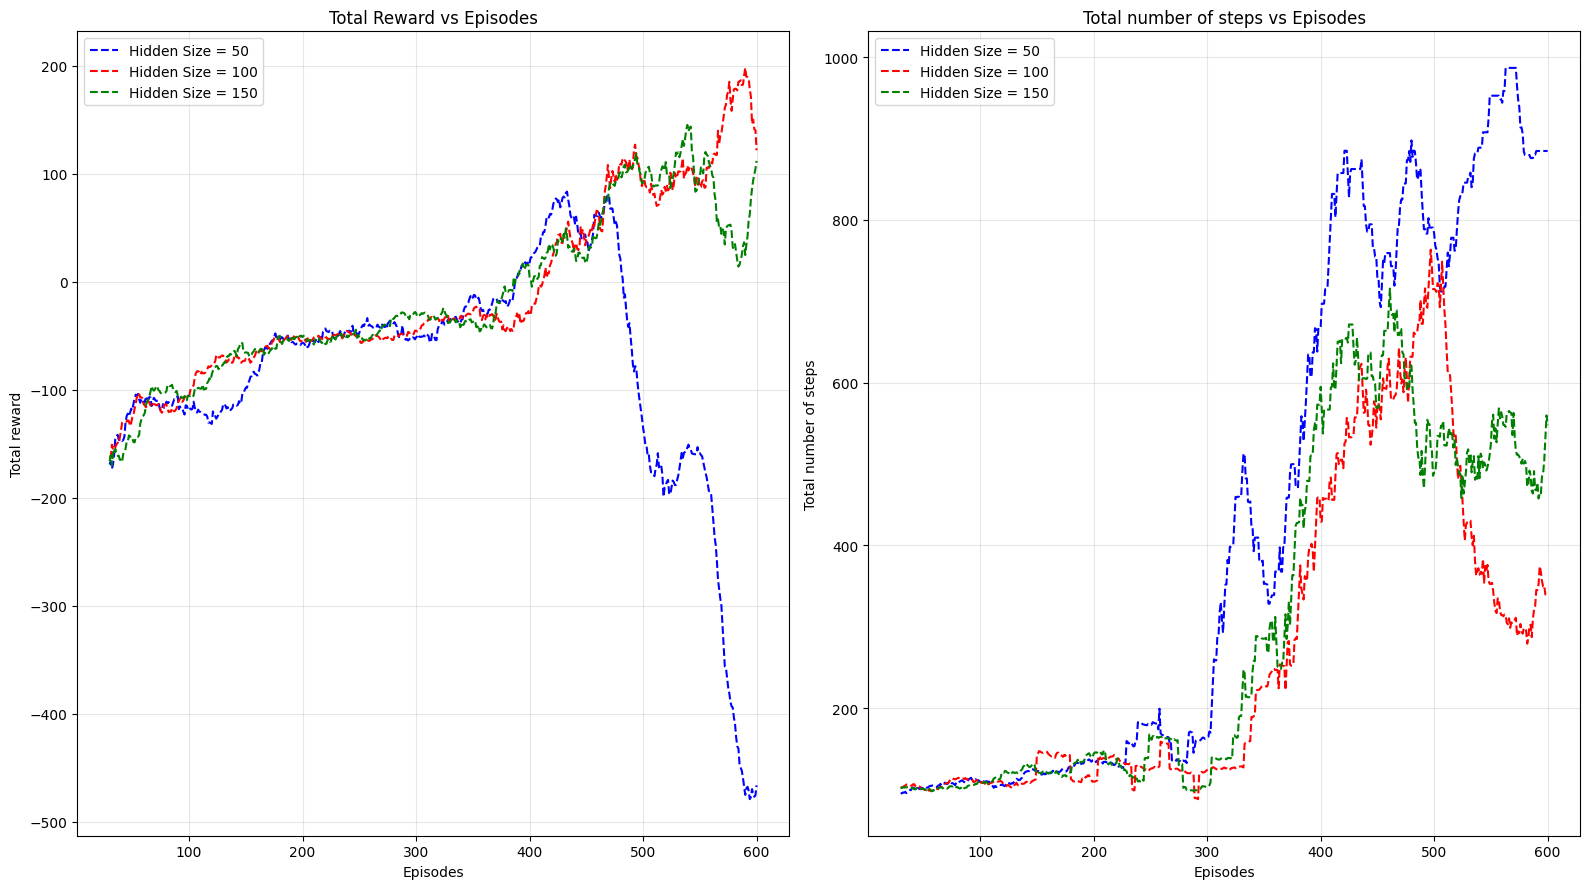

Training and comparison completed successfully.


In [70]:
compare_hidden_sizes()

Final Model training

Training Progress: 100%|██████████| 600/600 [16:40<00:00,  1.67s/it]


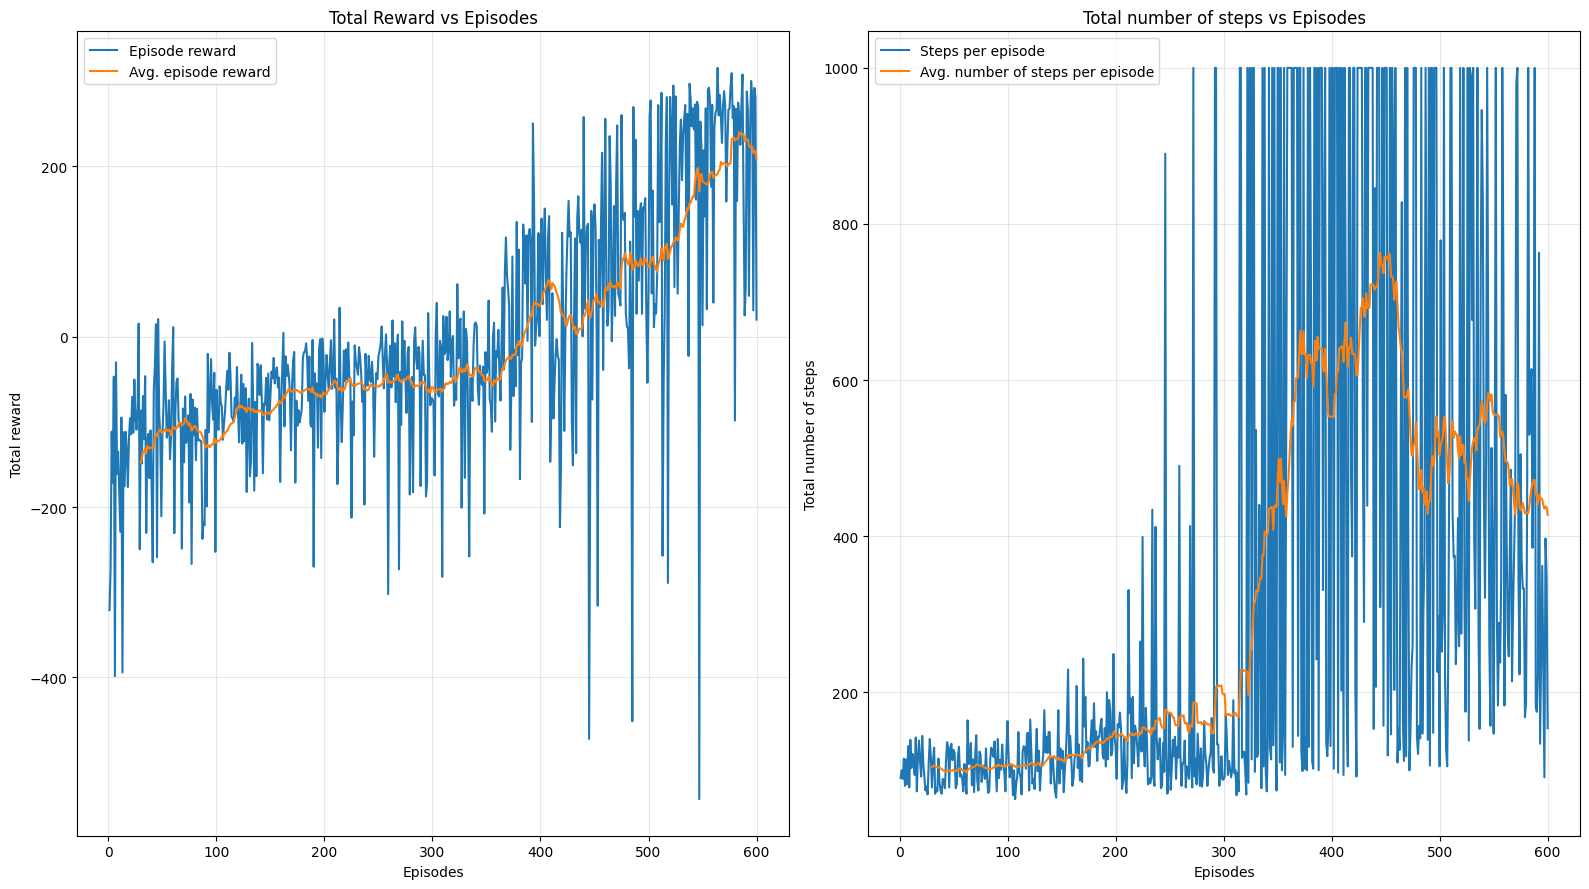

In [ ]:
episode_rewards, episode_steps = train_lunar_lander(hidden_size=120, n_episodes=600, discount_factor=1.0)
plot_training_results(episode_rewards, episode_steps)

Episode 1 completed. Total reward: 279.64
Episode 2 completed. Total reward: 279.66
Episode 3 completed. Total reward: 282.33
Episode 4 completed. Total reward: 289.47
Episode 5 completed. Total reward: 266.96


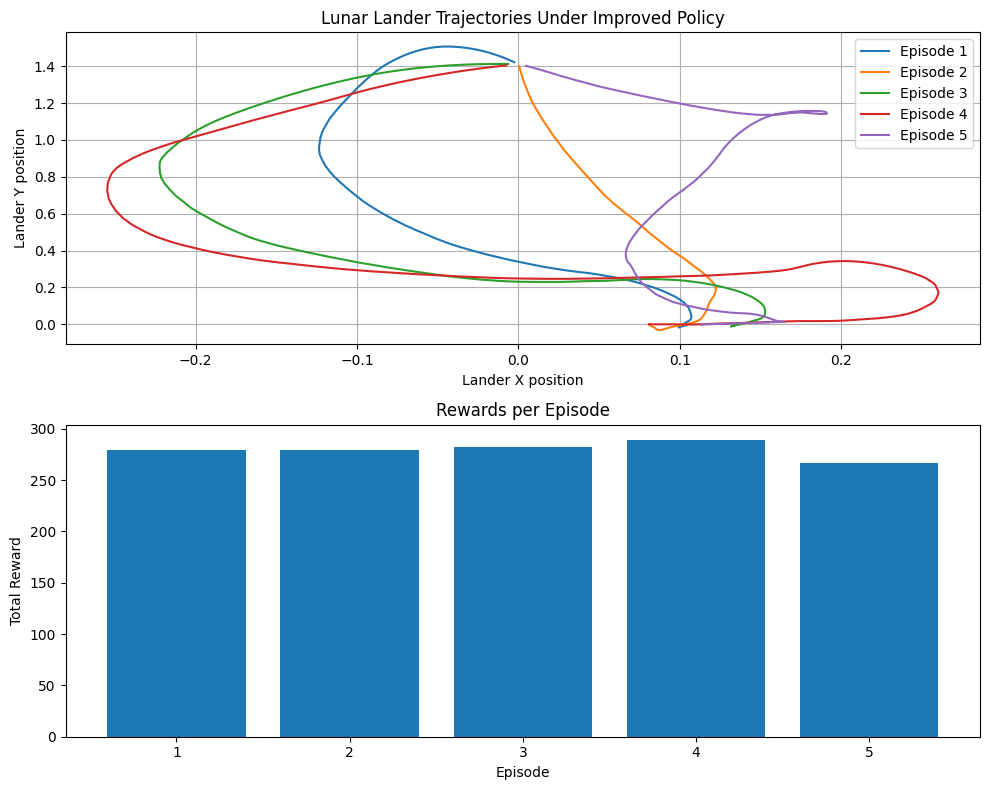

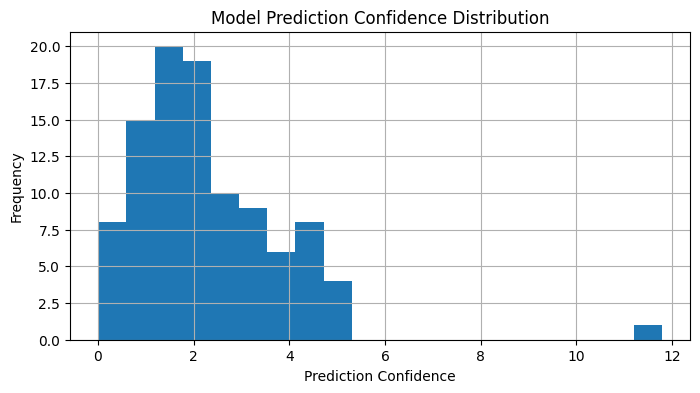

In [ ]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")
model = DeepQLearningAgent(input_size=8, output_size=4, hidden_size=80)
model.load_state_dict(torch.load("models/dqn_model.pth"))

# Run episodes with improved prediction techniques
num_episodes = 5  # Increased to get better statistics
trajectories = []
rewards_history = []

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    trajectory = []
    total_reward = 0
    
    
    while not done:
  
        action = model.predict(state, deterministic=True)
            
        next_state, reward, done, truncated, info = env.step(action)
        
        # Extract position data
        x, y = state[0], state[1]
        trajectory.append((x, y))
        
        total_reward += reward
        state = next_state
        
        # End episode if truncated
        if truncated:
            done = True
    
    print(f"Episode {episode+1} completed. Total reward: {total_reward:.2f}")
    trajectories.append(trajectory)
    rewards_history.append(total_reward)

env.close()

# Plot the trajectories
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
for i, trajectory in enumerate(trajectories):
    trajectory = np.array(trajectory)
    plt.plot(trajectory[:, 0], trajectory[:, 1], label=f"Episode {i+1}")
plt.xlabel("Lander X position")
plt.ylabel("Lander Y position")
plt.title("Lunar Lander Trajectories Under Improved Policy")
plt.legend()
plt.grid()

# Plot rewards
plt.subplot(2, 1, 2)
plt.bar(range(1, num_episodes+1), rewards_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Rewards per Episode")
plt.tight_layout()
plt.show()

# Calculate prediction confidence
def analyze_predictions(model, env, num_samples=100):
    state, _ = env.reset()
    confidences = []
    
    for _ in range(num_samples):
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = model(state_tensor)
            
            # Calculate confidence as difference between best and second best action
            sorted_q, _ = torch.sort(q_values, descending=True)
            confidence = (sorted_q[0][0] - sorted_q[0][1]).item()
            confidences.append(confidence)
            
            # Take a random action to explore state space
            action = env.action_space.sample()
            state, _, done, truncated, _ = env.step(action)
            
            if done or truncated:
                state, _ = env.reset()
    
    return confidences

confidences = analyze_predictions(model, env)
plt.figure(figsize=(8, 4))
plt.hist(confidences, bins=20)
plt.xlabel("Prediction Confidence")
plt.ylabel("Frequency")
plt.title("Model Prediction Confidence Distribution")
plt.grid()
plt.show()